In [73]:
sc.applicationId

'local-1698559178696'

In [74]:
# Import the library for ALS
from pyspark.mllib.recommendation import ALS

# Import the library for Logistic Regression
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

# Import the library for Kmeans
from pyspark.mllib.clustering import KMeans

In [75]:
# Load the data into RDD
data = sc.textFile(r'./ratings.csv')
# Split the RDD 
ratings = data.map(lambda l: l.split(','))
# Transform the ratings RDD  
ratings_final = ratings.map(lambda line: (int(line[0]), int(line[1]), float(line[2])))

# Split the data into training and test
training_data, test_data = ratings_final.randomSplit([0.8, 0.2])
ratings_final.first()

(1, 31, 2.5)

In [76]:
# Create the ALS model on the training data
model = ALS.train(training_data, rank=10, iterations=10)

# Drop the ratings column 
testdata_no_rating = test_data.map(lambda p: (p[0], p[1]))

# Predict the model  
predictions = model.predictAll(testdata_no_rating)

# Print the first rows of the RDD
predictions.take(2)

[Rating(user=80, product=1084, rating=3.6146012427947425),
 Rating(user=452, product=1084, rating=4.312736633087912)]

In [77]:
# Prepare ratings data
rates = ratings_final.map(lambda r: ((r[0], r[1]), r[2]))

# Prepare predictions data
preds = predictions.map(lambda r: ((r[0], r[1]), r[2]))

# Join the ratings data with predictions data
rates_and_preds = rates.join(preds)

# Calculate and print MSE
MSE = rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error of the model for the test data = {:.2f}".format(MSE))

Mean Squared Error of the model for the test data = 1.35


In [ ]:
sc.parallelize

In [125]:
# Load the datasets into RDDs
spam_rdd = sc.textFile(r'./spam.txt')
non_spam_rdd = sc.textFile(r'./ham.txt')

# Split the email messages into words
spam_words = sc.parallelize(spam_rdd.flatMap(lambda email: email.split(' ')).take(100))
non_spam_words = sc.parallelize(non_spam_rdd.flatMap(lambda email: email.split(' ')).take(100))

# Print the first element in the split RDD
print("The first element in spam_words is", spam_words.first())
print("The first element in non_spam_words is", non_spam_words.first())

The first element in spam_words is You
The first element in non_spam_words is Rofl.


In [130]:
conf = SparkConf().setAppName("dj").set('spark.executor.memory', '4g')
# create Spark session with the updated conf object
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# verify the updated executor memory value
print(spark.sparkContext.getConf().get('spark.executor.memory'))


None


In [131]:
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.regression import LabeledPoint
# Create a HashingTf instance with 200 features
tf = HashingTF(numFeatures=200)

# Map each word to one feature
spam_features = tf.transform(spam_words)
non_spam_features = tf.transform(non_spam_words)

# Label the features: 1 for spam, 0 for non-spam
spam_samples = spam_features.map(lambda features: LabeledPoint(1, features))
non_spam_samples = non_spam_features.map(lambda features: LabeledPoint(0, features))

# Combine the two datasets
samples = spam_samples.join(non_spam_samples)
spam_features.count()

100

In [132]:
# Split the data into training and testing
train_samples,test_samples = samples.randomSplit([0.8, 0.2])

from pyspark.mllib.classification import LogisticRegressionWithLBFGS
# Train the model
model = LogisticRegressionWithLBFGS.train(train_samples)

# Create a prediction label from the test data
predictions = model.predict(test_samples.map(lambda x: x.features))

# Combine original labels with the predicted labels
labels_and_preds = test_samples.map(lambda x: x.label).zip(predictions)

# Check the accuracy of the model on the test data
accuracy = labels_and_preds.filter(lambda x: x[0] == x[1]).count() / float(test_samples.count())
print("Model accuracy : {:.2f}".format(accuracy))

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 948.0 failed 1 times, most recent failure: Lost task 2.0 in stage 948.0 (TID 1296) (USHYDJDAMODH6.us.deloitte.com executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\spark\python\lib\pyspark.zip\pyspark\worker.py", line 1247, in main
  File "C:\spark\python\lib\pyspark.zip\pyspark\worker.py", line 1239, in process
  File "C:\spark\python\lib\pyspark.zip\pyspark\serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\spark\python\lib\pyspark.zip\pyspark\util.py", line 83, in wrapper
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\jdamodhar\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\rdd.py", line 4260, in map_values_fn
    return kv[0], f(kv[1])
           ~~^^^
TypeError: 'LabeledPoint' object is not subscriptable

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:751)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:451)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:181)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor128.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\spark\python\lib\pyspark.zip\pyspark\worker.py", line 1247, in main
  File "C:\spark\python\lib\pyspark.zip\pyspark\worker.py", line 1239, in process
  File "C:\spark\python\lib\pyspark.zip\pyspark\serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\spark\python\lib\pyspark.zip\pyspark\util.py", line 83, in wrapper
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\jdamodhar\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\rdd.py", line 4260, in map_values_fn
    return kv[0], f(kv[1])
           ~~^^^
TypeError: 'LabeledPoint' object is not subscriptable

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:751)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:451)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)


In [ ]:

# Load the dataset into a RDD
clusterRDD = sc.textFile(r'./5000_points.txt')

# Split the RDD based on tab
rdd_split = clusterRDD.map(lambda x: x.split("\t"))

# Transform the split RDD by creating a list of integers
rdd_split_int = rdd_split.map(lambda x: [int(x[0]), int(x[1])])

# Count the number of rows in RDD 
print("There are {} rows in the rdd_split_int dataset".format(rdd_split_int.count()))


There are 5000 rows in the rdd_split_int dataset


In [ ]:
from math import sqrt
def error(point):
    center = model.centers[model.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

In [ ]:
from pyspark.mllib.clustering import KMeans

# Train the model with clusters from 13 to 16 and compute WSSSE
for clst in range(13, 17):
    model = KMeans.train(rdd_split_int, clst, seed=1)
    WSSSE = rdd_split_int.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print("The cluster {} has Within Set Sum of Squared Error {}".format(clst, WSSSE))

# Train the model again with the best k
model = KMeans.train(rdd_split_int, k=16, seed=1)

# Get cluster centers
cluster_centers = model.clusterCenters

The cluster 13 has Within Set Sum of Squared Error 252060331.1260039
The cluster 14 has Within Set Sum of Squared Error 215808893.2796594
The cluster 15 has Within Set Sum of Squared Error 169394691.52639425
The cluster 16 has Within Set Sum of Squared Error 168103213.0429197


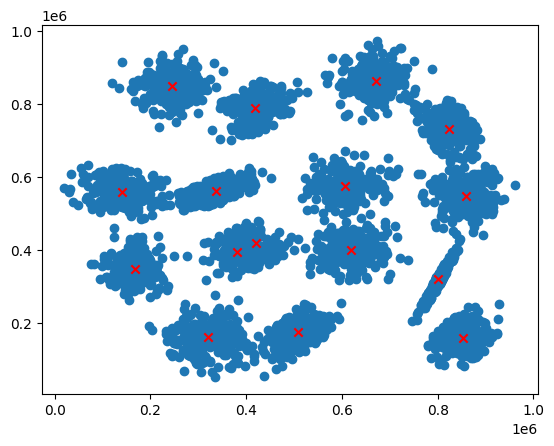

In [ ]:
# Convert rdd_split_int RDD into Spark DataFrame and then to Pandas DataFrame
rdd_split_int_df_pandas = spark.createDataFrame(rdd_split_int, schema=["col1", "col2"]).toPandas()

# Convert cluster_centers to a pandas DataFrame
cluster_centers_pandas = pd.DataFrame(cluster_centers, columns=["col1", "col2"])

# Create an overlaid scatter plot of clusters and centroids
plt.scatter(rdd_split_int_df_pandas["col1"], rdd_split_int_df_pandas["col2"])
plt.scatter(cluster_centers_pandas["col1"], cluster_centers_pandas["col2"], color="red", marker="x")
plt.show()

In [ ]:
sc

<SparkContext master=local[4] appName=dj>